# Imports

In [1]:

from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Point



pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 500)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Read in data from parquet files

In [3]:
race_df = pd.read_parquet('/content/drive/MyDrive/200_Final_Project/ColabSharedFolder/race_df.parquet')

In [4]:
weather_df = pd.read_parquet('/content/drive/MyDrive/200_Final_Project/ColabSharedFolder/summarized_weather.parquet')

## Merge datasets into a master dataset

In [5]:
df = pd.merge(race_df, weather_df, on='race_id', how='left')

In [6]:
df.head()

,driverId,first_name,last_name,team_name,race_id,race_date,race_time_utc,location,country,lat,lng,circuit_name,circuit_ref,round,starting_race_position,team_position_after_race,laps,fastest_lap,race_time,race_points,status,driver_current_points,driver_current_position,constructor_current_points,constructor_position,ending_race_position,F/DNF,wet_conditions,cold_conditions,hot_conditions,windy_conditions
0,20,Sebastian,Vettel,Ferrari,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,3,1,58,53,5373283,25.0,Finished,25.0,1.0,40.0,1.0,1,0,0,0,0,0
1,1,Lewis,Hamilton,Mercedes,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,1,2,58,50,5378319,18.0,Finished,18.0,2.0,22.0,2.0,2,0,0,0,0,0
2,8,Kimi,Räikkönen,Ferrari,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,2,3,58,57,5379592,15.0,Finished,15.0,3.0,40.0,1.0,3,0,0,0,0,0
3,817,Daniel,Ricciardo,Red Bull,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,8,4,58,54,5380352,12.0,Finished,12.0,4.0,20.0,3.0,4,0,0,0,0,0
4,4,Fernando,Alonso,McLaren,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,10,5,58,57,5401169,10.0,Finished,10.0,5.0,12.0,4.0,5,0,0,0,0,0


In [7]:
df.columns

Index(['driverId', 'first_name', 'last_name', 'team_name', 'race_id',
       'race_date', 'race_time_utc', 'location', 'country', 'lat', 'lng',
       'circuit_name', 'circuit_ref', 'round', 'starting_race_position',
       'team_position_after_race', 'laps', 'fastest_lap', 'race_time',
       'race_points', 'status', 'driver_current_points',
       'driver_current_position', 'constructor_current_points',
       'constructor_position', 'ending_race_position', 'F/DNF',
       'wet_conditions', 'cold_conditions', 'hot_conditions',
       'windy_conditions'],
      dtype='object')

In [8]:
df['last_name'].nunique()

25

In [9]:
df.shape

(2268, 31)

In [10]:
df['team_name'].unique()

array(['Ferrari', 'Mercedes', 'Red Bull', 'McLaren', 'Renault',
       'Force India', 'Williams', 'Haas', 'Toro Rosso', 'Alfa Romeo',
       'Racing Point', 'AlphaTauri', 'Aston Martin', 'Alpine'],
      dtype=object)

# Create subsets for data in abnormal weather conditions and normal weather condition to perform analysis on

In [11]:
abnormal_df = df[df[['wet_conditions', 'cold_conditions', 'hot_conditions', 'windy_conditions']].max(axis=1) > 0]

In [12]:
abnormal_df.shape

(1359, 31)

In [13]:
abnormal_df.race_id.nunique()

75

In [14]:
normal_df = df[df[['wet_conditions', 'cold_conditions', 'hot_conditions', 'windy_conditions']].max(axis=1) == 0]

In [15]:
normal_df.shape

(909, 31)

In [16]:
normal_df.race_id.nunique()

50

In [17]:
ab_races = abnormal_df['race_id'].nunique()
norm_races = normal_df['race_id'].nunique()
print(f'There were {ab_races} races under abnormal weather conditions, compared to {norm_races} races under normal weather condition.')

There were 75 races under abnormal weather conditions, compared to 50 races under normal weather condition.


In [18]:
ab_name = abnormal_df['last_name'].nunique()
norm_name = normal_df['last_name'].nunique()
print(f'There were {ab_name} drivers who drove under abnormal weather conditions, compared to {norm_name} drivers who drove under normal weather condition.')

There were 25 drivers who drove under abnormal weather conditions, compared to 25 drivers who drove under normal weather condition.


# Q1: How have abnormal weather conditions influenced driver standings at the end of each season from 2018 - 2023?

We will be using the difference between `starting_race_position` and `finishing_race_position` columns and comparing how these values differ for each driver based on normal and abnormal weather conditions.

In [19]:
df.head()

,driverId,first_name,last_name,team_name,race_id,race_date,race_time_utc,location,country,lat,lng,circuit_name,circuit_ref,round,starting_race_position,team_position_after_race,laps,fastest_lap,race_time,race_points,status,driver_current_points,driver_current_position,constructor_current_points,constructor_position,ending_race_position,F/DNF,wet_conditions,cold_conditions,hot_conditions,windy_conditions
0,20,Sebastian,Vettel,Ferrari,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,3,1,58,53,5373283,25.0,Finished,25.0,1.0,40.0,1.0,1,0,0,0,0,0
1,1,Lewis,Hamilton,Mercedes,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,1,2,58,50,5378319,18.0,Finished,18.0,2.0,22.0,2.0,2,0,0,0,0,0
2,8,Kimi,Räikkönen,Ferrari,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,2,3,58,57,5379592,15.0,Finished,15.0,3.0,40.0,1.0,3,0,0,0,0,0
3,817,Daniel,Ricciardo,Red Bull,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,8,4,58,54,5380352,12.0,Finished,12.0,4.0,20.0,3.0,4,0,0,0,0,0
4,4,Fernando,Alonso,McLaren,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.968,Albert Park Grand Prix Circuit,albert_park,1,10,5,58,57,5401169,10.0,Finished,10.0,5.0,12.0,4.0,5,0,0,0,0,0


In [22]:
df[df['F/DNF'] == 1]

,driverId,first_name,last_name,team_name,race_id,race_date,race_time_utc,location,country,lat,lng,circuit_name,circuit_ref,round,starting_race_position,team_position_after_race,laps,fastest_lap,race_time,race_points,status,driver_current_points,driver_current_position,constructor_current_points,constructor_position,ending_race_position,F/DNF,wet_conditions,cold_conditions,hot_conditions,windy_conditions
12,154,Romain,Grosjean,Haas,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.96800,Albert Park Grand Prix Circuit,albert_park,1,6,\N,24,23,\N,0.0,Wheel,0.0,16.0,0.0,10.0,16,1,0,0,0,0
13,825,Kevin,Magnussen,Haas,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.96800,Albert Park Grand Prix Circuit,albert_park,1,5,\N,22,21,\N,0.0,Wheel,0.0,17.0,0.0,10.0,17,1,0,0,0,0
14,842,Pierre,Gasly,Toro Rosso,989,2018-03-25,05:10:00,Melbourne,Australia,-37.8497,144.96800,Albert Park Grand Prix Circuit,albert_park,1,20,\N,13,13,\N,0.0,Engine,0.0,18.0,0.0,9.0,18,1,0,0,0,0
27,8,Kimi,Räikkönen,Ferrari,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.51060,Bahrain International Circuit,bahrain,2,2,\N,35,22,\N,0.0,Wheel,15.0,5.0,65.0,1.0,18,1,0,0,1,0
28,830,Max,Verstappen,Red Bull,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.51060,Bahrain International Circuit,bahrain,2,15,\N,3,\N,\N,0.0,Puncture,8.0,10.0,20.0,4.0,19,1,0,0,1,0
29,817,Daniel,Ricciardo,Red Bull,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.51060,Bahrain International Circuit,bahrain,2,4,\N,1,\N,\N,0.0,Electrical,12.0,8.0,20.0,4.0,20,1,0,0,1,0
54,822,Valtteri,Bottas,Mercedes,992,2018-04-29,12:10:00,Baku,Azerbaijan,40.3725,49.85330,Baku City Circuit,baku,4,3,\N,48,37,\N,0.0,Puncture,40.0,4.0,110.0,2.0,14,1,0,4,0,2
55,154,Romain,Grosjean,Haas,992,2018-04-29,12:10:00,Baku,Azerbaijan,40.3725,49.85330,Baku City Circuit,baku,4,20,\N,42,34,\N,0.0,Accident,0.0,19.0,11.0,8.0,15,1,0,4,0,2
56,830,Max,Verstappen,Red Bull,992,2018-04-29,12:10:00,Baku,Azerbaijan,40.3725,49.85330,Baku City Circuit,baku,4,5,\N,39,31,\N,0.0,Collision,18.0,8.0,55.0,3.0,16,1,0,4,0,2
57,817,Daniel,Ricciardo,Red Bull,992,2018-04-29,12:10:00,Baku,Azerbaijan,40.3725,49.85330,Baku City Circuit,baku,4,4,\N,39,34,\N,0.0,Collision,37.0,5.0,55.0,3.0,17,1,0,4,0,2


In [20]:
abnormal_df['position_delta'] = abnormal_df.starting_race_position - abnormal_df.ending_race_position
normal_df['position_delta'] = normal_df.starting_race_position - normal_df.ending_race_position

<ipython-input-20-94ce185cf06b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal_df['position_delta'] = abnormal_df.starting_race_position - abnormal_df.ending_race_position
<ipython-input-20-94ce185cf06b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df['position_delta'] = normal_df.starting_race_position - normal_df.ending_race_position


In [ ]:
abnormal_driver = abnormal_df.groupby('last_name')['position_delta'].mean().reset_index()

In [ ]:
normal_driver = normal_df.groupby('last_name')['position_delta'].mean().reset_index()

In [ ]:
driver_merge = pd.merge(normal_driver, abnormal_driver, on='last_name', how='inner')

In [ ]:
driver_merge.columns = ['last_name', 'normal_delta', 'abnormal_delta']
driver_merge.head()

,last_name,normal_delta,abnormal_delta
0,Albon,0.00000,0.160000
1,Alonso,0.37500,-0.629630
2,Bottas,-2.30000,-0.786667
3,Gasly,-0.62000,-0.773333
4,Giovinazzi,1.37037,-0.242424


In [ ]:
driver_merge.sort_values(by='normal_delta', ascending=True).head()

,last_name,normal_delta,abnormal_delta
5,Grosjean,-3.260870,-1.606061
7,Hülkenberg,-2.681818,-2.048780
2,Bottas,-2.300000,-0.786667
11,Magnussen,-2.263158,-1.274194
21,Tsunoda,-1.320000,-1.024390


In [ ]:
driver_merge.sort_values(by='abnormal_delta', ascending=True).head()

,last_name,normal_delta,abnormal_delta
10,Leclerc,-0.261905,-2.590164
7,Hülkenberg,-2.681818,-2.048780
5,Grosjean,-3.260870,-1.606061
17,Räikkönen,1.676471,-1.488889
16,Russell,0.642857,-1.274194


## Check for drivers who are constantly performing well under any weather conditions

In [ ]:
driver_merge[(driver_merge.normal_delta > 0) & (driver_merge.abnormal_delta > 0)]

,last_name,normal_delta,abnormal_delta
8,Kvyat,1.529412,1.238095
9,Latifi,0.666667,0.941176
19,Schumacher,0.277778,0.040000
20,Stroll,0.120000,1.753425


In [ ]:
driver_merge

NameError: ignored

## Visualization

In [ ]:
driver_merge = driver_merge.rename(columns={'abnormal_delta':'Abnormal', 'normal_delta':'Normal'})

In [ ]:
melted_q2 = driver_merge.melt(id_vars=['last_name'], var_name='Weather Conditions', value_vars=['Abnormal', 'Normal'], value_name='Time difference')

In [ ]:
for i in range(50):
  if melted_q2['Time difference'][i] < 0:
    melted_q2['Weather Conditions'][i] = melted_q2['Weather Conditions'][i] + ' Negative'
  else:
    melted_q2['Weather Conditions'][i] = melted_q2['Weather Conditions'][i] + ' Positive'

<ipython-input-31-ccd966e4a46c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_q2['Weather Conditions'][i] = melted_q2['Weather Conditions'][i] + ' Positive'
<ipython-input-31-ccd966e4a46c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_q2['Weather Conditions'][i] = melted_q2['Weather Conditions'][i] + ' Negative'


In [ ]:
contrasting_pastel_palette = [
    sns.color_palette("pastel")[1],
    sns.color_palette("deep")[1],
    sns.color_palette("pastel")[0],
    sns.color_palette("deep")[0]
]

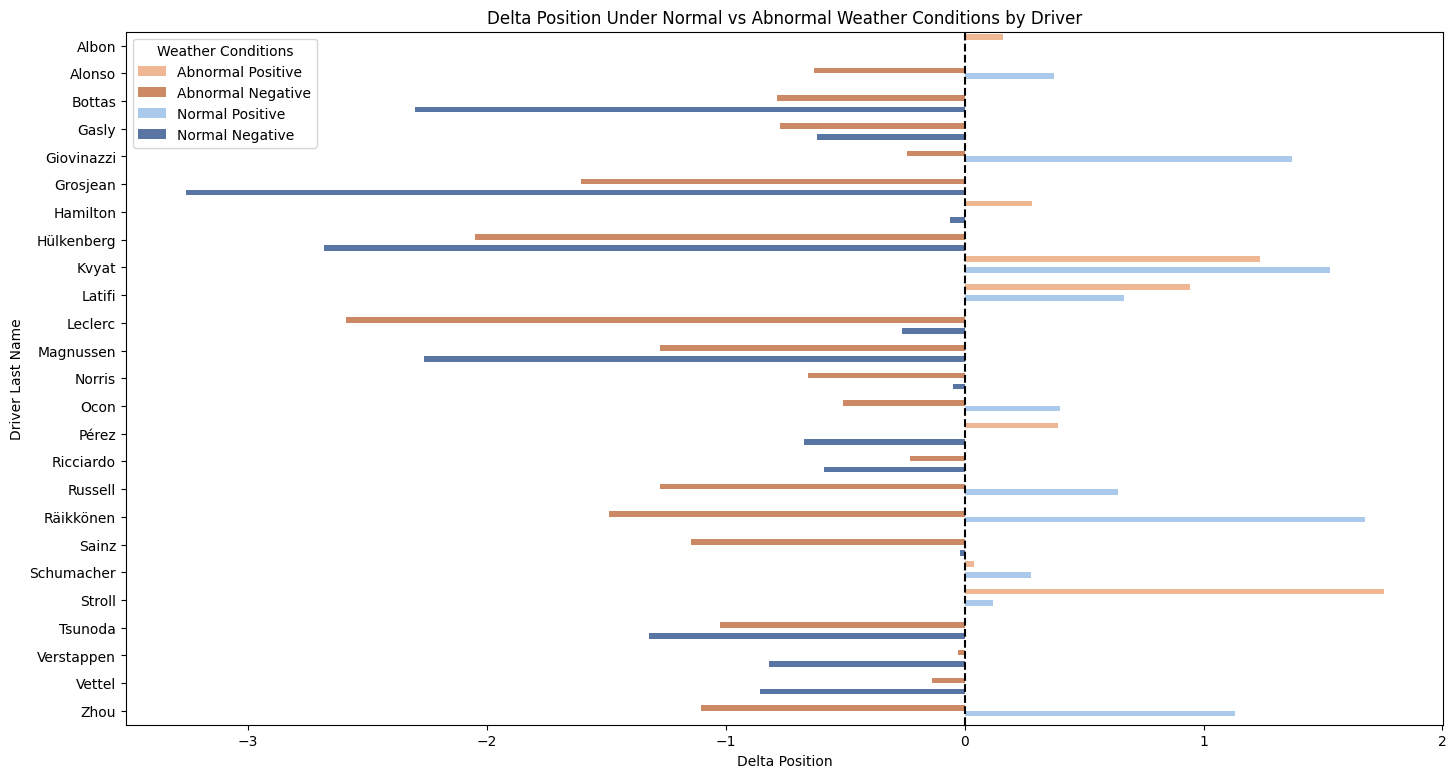

In [ ]:
plt.figure(figsize=(17, 9))
sns.barplot(data=melted_q2, x='Time difference', y='last_name', hue='Weather Conditions', orient='h', palette=contrasting_pastel_palette)
plt.axvline(x = 0, color = 'k', linestyle='--')
plt.title('Delta Position Under Normal vs Abnormal Weather Conditions by Driver')
plt.ylabel('Driver Last Name')
plt.xlabel('Delta Position')
plt.show()

# Q2: Do specific drivers exhibit different crash rates under varying weather conditions?

We will use a weighted average to calculate the likelihood that a driver did not finish a race under abnormal and normal weather conditions to take into consideration the amount of races that they participated in. The formula for the weighted average is:

$$
\text{Weighted Average} = \frac{\sum (\text{Weight}_i \times \text{Value}_i)}{\sum \text{Weight}_i}
$$

In our case, the formula would represent:

$$
\text{Weighted Average} = \frac{\sum (\text{Mean of Weather Condition}_i \times \text{Count of Races Driven by Driver}_i)}{\sum \text{Total Count of Races in Weather Condition}_i}
$$

In [ ]:
by_ab_driver = abnormal_df.groupby(['team_name', 'last_name'])
abnormal_ratio_df = by_ab_driver.agg({'F/DNF': ['mean', 'sum','count']}).reset_index()

In [ ]:
by_norm_driver = normal_df.groupby(['team_name', 'last_name'])
normal_ratio_df = by_norm_driver.agg({'F/DNF': ['mean', 'sum','count']}).reset_index()

In [ ]:
for a in [abnormal_ratio_df, normal_ratio_df]:
    a.columns = ['team_name', 'last_name', 'mean', 'sum', 'count']

In [ ]:
merged_df = pd.merge(abnormal_ratio_df, normal_ratio_df, on=['team_name', 'last_name'], suffixes=('_abnormal', '_normal'))

In [ ]:
merged_df.head()

,team_name,last_name,mean_abnormal,sum_abnormal,count_abnormal,mean_normal,sum_normal,count_normal
0,Alfa Romeo,Bottas,0.172414,5,29,0.266667,4,15
1,Alfa Romeo,Giovinazzi,0.151515,5,33,0.037037,1,27
2,Alfa Romeo,Räikkönen,0.093750,3,32,0.076923,2,26
3,Alfa Romeo,Zhou,0.241379,7,29,0.066667,1,15
4,AlphaTauri,Gasly,0.205882,7,34,0.111111,3,27


In [ ]:
merged_df['abnormal_weighted_avg'] = (merged_df['mean_abnormal'] * merged_df['count_abnormal']) / abnormal_df['race_id'].nunique()

In [ ]:
merged_df['normal_weighted_avg'] = (merged_df['mean_normal'] * merged_df['count_normal']) / normal_df['race_id'].nunique()

In [ ]:
merged_df.head()

,team_name,last_name,mean_abnormal,sum_abnormal,count_abnormal,mean_normal,sum_normal,count_normal,abnormal_weighted_avg,normal_weighted_avg
0,Alfa Romeo,Bottas,0.172414,5,29,0.266667,4,15,0.066667,0.08
1,Alfa Romeo,Giovinazzi,0.151515,5,33,0.037037,1,27,0.066667,0.02
2,Alfa Romeo,Räikkönen,0.093750,3,32,0.076923,2,26,0.040000,0.04
3,Alfa Romeo,Zhou,0.241379,7,29,0.066667,1,15,0.093333,0.02
4,AlphaTauri,Gasly,0.205882,7,34,0.111111,3,27,0.093333,0.06


In [ ]:
merged_df.sum_abnormal.sum()/merged_df.count_abnormal.sum()

0.152317880794702

In [ ]:
merged_df.count_abnormal.sum()

1359

In [ ]:
merged_df.sum_normal.sum()/merged_df.count_normal.sum()

0.1496149614961496

In [ ]:
merged_df.count_normal.sum()

909

In [ ]:
merged_df.describe()

,mean_abnormal,sum_abnormal,count_abnormal,mean_normal,sum_normal,count_normal,abnormal_weighted_avg,normal_weighted_avg
count,49.000000,49.000000,49.000000,49.000000,49.00000,49.000000,49.000000,49.000000
mean,0.159745,4.224490,27.734694,0.149064,2.77551,18.551020,0.056327,0.055510
std,0.099080,2.917371,17.034005,0.098093,2.15315,11.826984,0.038898,0.043063
min,0.000000,0.000000,6.000000,0.000000,0.00000,1.000000,0.000000,0.000000
25%,0.093750,2.000000,13.000000,0.076923,1.00000,8.000000,0.026667,0.020000
50%,0.153846,4.000000,25.000000,0.157895,2.00000,16.000000,0.053333,0.040000
75%,0.212121,7.000000,34.000000,0.222222,4.00000,25.000000,0.093333,0.080000
max,0.461538,12.000000,75.000000,0.375000,8.00000,50.000000,0.160000,0.160000


## Check for drivers who are ....

In [ ]:
merged_df[(merged_df.abnormal_weighted_avg < 0.05) & (merged_df.normal_weighted_avg < 0.05)]

,team_name,last_name,mean_abnormal,sum_abnormal,count_abnormal,mean_normal,sum_normal,count_normal,abnormal_weighted_avg,normal_weighted_avg
2,Alfa Romeo,Räikkönen,0.093750,3,32,0.076923,2,26,0.040000,0.04
5,AlphaTauri,Kvyat,0.000000,0,9,0.250000,2,8,0.000000,0.04
6,AlphaTauri,Ricciardo,0.000000,0,6,0.000000,0,1,0.000000,0.00
9,Alpine,Gasly,0.187500,3,16,0.000000,0,6,0.040000,0.00
11,Aston Martin,Alonso,0.062500,1,16,0.000000,0,5,0.013333,0.00
19,Force India,Pérez,0.076923,1,13,0.125000,1,8,0.013333,0.02
21,Haas,Hülkenberg,0.062500,1,16,0.166667,1,6,0.013333,0.02
23,Haas,Schumacher,0.120000,3,25,0.111111,2,18,0.040000,0.04
29,Mercedes,Hamilton,0.040541,3,74,0.040816,2,49,0.040000,0.04
31,Racing Point,Pérez,0.100000,2,20,0.125000,2,16,0.026667,0.04


## Visualization

In [ ]:
unique_teams = merged_df['team_name'].unique()
n_teams = len(unique_teams)
y_axis_range = [0,.25]

In [ ]:
merged_df = merged_df.rename(columns={'abnormal_weighted_avg':'Abnormal', 'normal_weighted_avg':'Normal'})

In [ ]:
weather_palette = {
    'Normal': sns.color_palette("pastel")[0],
    'Abnormal': sns.color_palette("pastel")[1],
}

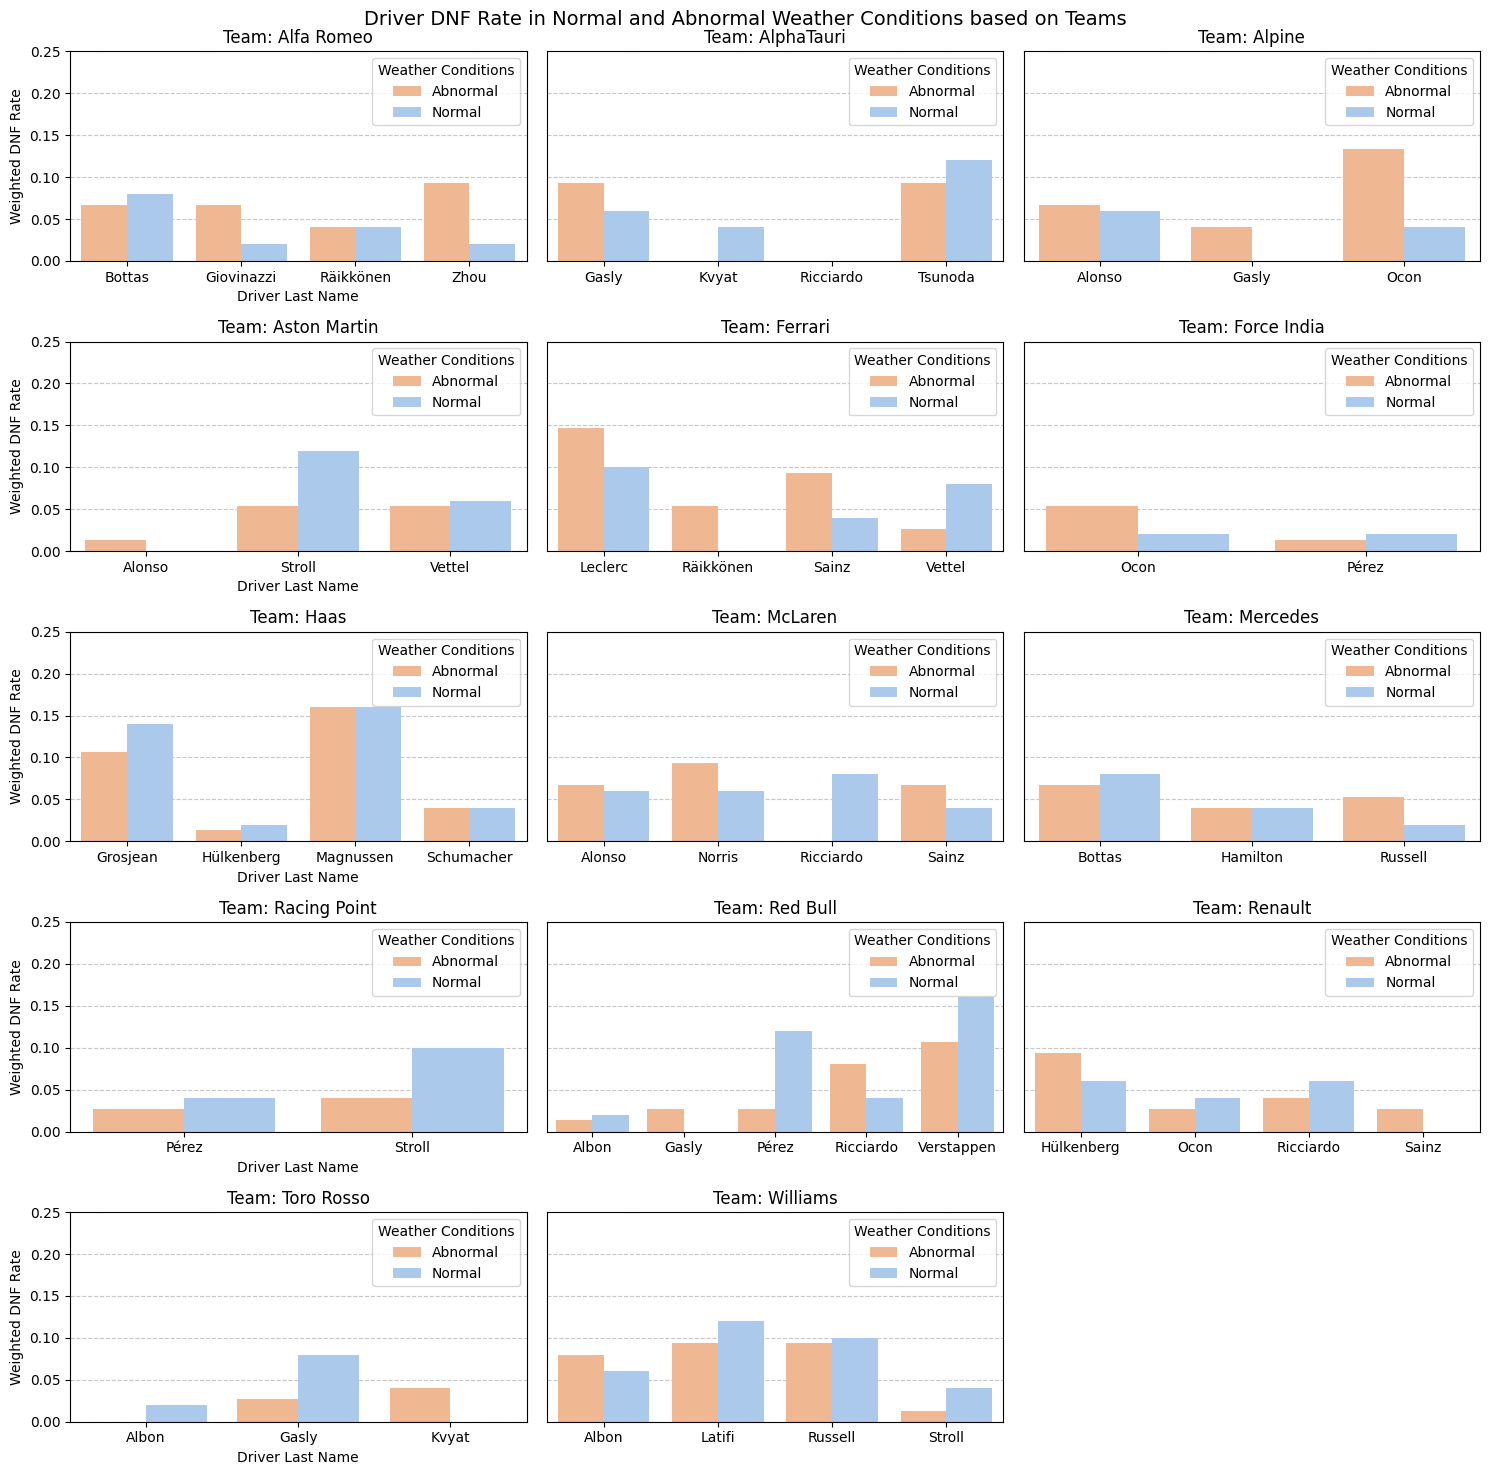

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(15, 15), squeeze=False)
axes_flat = axes.flatten()
for i, team in enumerate(unique_teams):
  team_data = merged_df[merged_df['team_name'] == team]
  grouped_team_data = team_data.melt(id_vars=['last_name'], value_vars=['Abnormal', 'Normal'], var_name= 'Weather Conditions', value_name='Weighted DNF Rate')
  sns.barplot(data=grouped_team_data, x='last_name', y='Weighted DNF Rate',hue='Weather Conditions', ax=axes_flat[i], palette=weather_palette)
  axes_flat[i].set_title(f"Team: {team}")
  axes_flat[i].set_ylim(y_axis_range)

  if i % 3 == 0:
    axes_flat[i].set_xlabel('Driver Last Name')
  else:
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_yticklabels([])
    axes_flat[i].tick_params(left = False)
  axes_flat[i].set_axisbelow(True)
  axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_flat)):
  axes_flat[j].axis('off')

plt.suptitle('Driver DNF Rate in Normal and Abnormal Weather Conditions based on Teams', fontsize=14)
plt.tight_layout()
plt.show()

## Check DNF Rate for Each Team

In [ ]:
merged_df.groupby('team_name')['Abnormal', 'Normal'].mean()

<ipython-input-52-ef89468db05b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df.groupby('team_name')['Abnormal', 'Normal'].mean()


,Abnormal,Normal
team_name,,
Alfa Romeo,0.066667,0.040000
AlphaTauri,0.046667,0.055000
Alpine,0.080000,0.033333
Aston Martin,0.040000,0.060000
Ferrari,0.080000,0.055000
Force India,0.033333,0.020000
Haas,0.080000,0.090000
McLaren,0.056667,0.060000
Mercedes,0.053333,0.046667


In [ ]:
team_merge = merged_df.groupby('team_name')['sum_abnormal', 'count_abnormal', 'sum_normal', 'count_normal'].sum().reset_index()

<ipython-input-53-5dda647a6137>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  team_merge = merged_df.groupby('team_name')['sum_abnormal', 'count_abnormal', 'sum_normal', 'count_normal'].sum().reset_index()


In [ ]:
team_merge['dnf_abnormal'] = team_merge.sum_abnormal/team_merge.count_abnormal
team_merge['dnf_normal'] = team_merge.sum_normal/team_merge.count_normal

In [ ]:
team_merge['Abnormal'] = team_merge.dnf_abnormal * team_merge.count_abnormal/team_merge.count_abnormal.max()
team_merge['Normal'] = team_merge.dnf_normal * team_merge.count_normal/team_merge.count_normal.max()

In [ ]:
team_merge[['team_name', 'dnf_abnormal', 'dnf_normal', 'Abnormal', 'Normal']].sort_values(by='Abnormal', ascending=False).reset_index(drop = True)

,team_name,dnf_abnormal,dnf_normal,Abnormal,Normal
0,Ferrari,0.161074,0.110000,0.160000,0.11
1,Haas,0.176471,0.211765,0.160000,0.18
2,Williams,0.192661,0.213333,0.140000,0.16
3,Alfa Romeo,0.162602,0.096386,0.133333,0.08
4,Red Bull,0.126667,0.170000,0.126667,0.17
5,Alpine,0.219512,0.100000,0.120000,0.05
6,McLaren,0.141667,0.139535,0.113333,0.12
7,AlphaTauri,0.155556,0.180328,0.093333,0.11
8,Renault,0.205882,0.166667,0.093333,0.08
9,Mercedes,0.080537,0.070000,0.080000,0.07


In [ ]:
team_merge[['team_name', 'Abnormal', 'Normal']].sort_values(by='Abnormal', ascending=False).reset_index(drop = True)

,team_name,Abnormal,Normal
0,Ferrari,0.160000,0.11
1,Haas,0.160000,0.18
2,Williams,0.140000,0.16
3,Alfa Romeo,0.133333,0.08
4,Red Bull,0.126667,0.17
5,Alpine,0.120000,0.05
6,McLaren,0.113333,0.12
7,AlphaTauri,0.093333,0.11
8,Renault,0.093333,0.08
9,Mercedes,0.080000,0.07


# Q3: What patterns emerge in driver’s performances across different weather conditions?

We will be examining the different weather conditions and determine those suitable for our analysis. Since different teams race with different cars, we will only be comparing people on the same team to ensure that the result is comparable. `Performance` referred to in this question is the finished position of the driver for that race.

In [ ]:
abnormal_df.head()

,driverId,first_name,last_name,team_name,race_id,race_date,race_time_utc,location,country,lat,lng,circuit_name,circuit_ref,round,starting_race_position,team_position_after_race,laps,fastest_lap,race_time,race_points,status,driver_current_points,driver_current_position,constructor_current_points,constructor_position,ending_race_position,F/DNF,wet_conditions,cold_conditions,hot_conditions,windy_conditions,position_delta
15,20,Sebastian,Vettel,Ferrari,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.5106,Bahrain International Circuit,bahrain,2,1,1,57,21,5521940,25.0,Finished,50.0,1.0,65.0,1.0,1,0,0,0,1,0,0
16,822,Valtteri,Bottas,Mercedes,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.5106,Bahrain International Circuit,bahrain,2,3,2,57,22,5522639,18.0,Finished,22.0,3.0,55.0,2.0,2,0,0,0,1,0,1
17,1,Lewis,Hamilton,Mercedes,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.5106,Bahrain International Circuit,bahrain,2,9,3,57,51,5528452,15.0,Finished,33.0,2.0,55.0,2.0,3,0,0,0,1,0,6
18,842,Pierre,Gasly,Toro Rosso,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.5106,Bahrain International Circuit,bahrain,2,5,4,57,46,5584174,12.0,Finished,12.0,7.0,12.0,6.0,4,0,0,0,1,0,1
19,825,Kevin,Magnussen,Haas,990,2018-04-08,15:10:00,Sakhir,Bahrain,26.0325,50.5106,Bahrain International Circuit,bahrain,2,6,5,57,29,5596986,10.0,Finished,10.0,9.0,10.0,7.0,5,0,0,0,1,0,1


In [ ]:
abnormal_df.shape

(1359, 32)

In [ ]:
abnormal_df = abnormal_df.sort_values(by='last_name')

In [ ]:
hot_df = abnormal_df[abnormal_df[['hot_conditions']].max(axis=1) > 0]
hot_df.shape

(579, 32)

In [ ]:
windy_df = abnormal_df[abnormal_df[['windy_conditions']].max(axis=1) > 0]
windy_df.shape

(15, 32)

In [ ]:
cold_df = abnormal_df[abnormal_df[['cold_conditions']].max(axis=1) > 0]
cold_df.shape

(367, 32)

In [ ]:
wet_df = abnormal_df[abnormal_df[['wet_conditions']].max(axis=1) > 0]
wet_df.shape

(687, 32)

In [ ]:
cold_wet_df = abnormal_df[(abnormal_df['cold_conditions'] > 0) & (abnormal_df['wet_conditions'] > 0)]
cold_wet_df.shape

(169, 32)

In [ ]:
cold_windy_df = abnormal_df[(abnormal_df['cold_conditions'] > 0) & (abnormal_df['windy_conditions'] > 0)]
cold_windy_df.shape

(15, 32)

In [ ]:
windy_wet_df = abnormal_df[(abnormal_df['wet_conditions'] > 0) & (abnormal_df['windy_conditions'] > 0)]
windy_wet_df.shape

(0, 32)

In [ ]:
hot_windy_df = abnormal_df[(abnormal_df['hot_conditions'] > 0) & (abnormal_df['windy_conditions'] > 0)]
hot_windy_df.shape

(0, 32)

Based on the above dataframes, we decided to only focus on the conditions that have sufficient data points to work with. Those weather conditions are: <br>
1. Hot condition<br>
2. Cold condition<br>
3. Wet condition<br>
4. Cold/wet condition<br>
5. Normal weather condition

## Hot Condition

In [ ]:
hot_df = hot_df[['team_name', 'last_name', 'ending_race_position']]

In [ ]:
hot_df = hot_df.rename(columns={'ending_race_position':'Ending Race Position'})

In [ ]:
hot_df.groupby(['team_name','last_name'])['Ending Race Position'].mean()

team_name     last_name 
Alfa Romeo    Bottas        12.214286
              Giovinazzi    13.153846
              Räikkönen     13.000000
              Zhou          15.000000
AlphaTauri    Gasly         12.062500
              Kvyat          9.250000
              Ricciardo     13.000000
              Tsunoda       12.750000
Alpine        Alonso         9.833333
              Gasly         11.125000
              Ocon          11.400000
Aston Martin  Alonso         8.500000
              Stroll        11.368421
              Vettel        11.727273
Ferrari       Leclerc        8.038462
              Räikkönen      9.600000
              Sainz          7.950000
              Vettel         5.083333
Force India   Ocon          13.400000
              Pérez         12.800000
Haas          Grosjean      14.500000
              Hülkenberg    14.500000
              Magnussen     14.423077
              Schumacher    15.750000
McLaren       Alonso         8.200000
              Norris     

In [ ]:
palette = sns.color_palette("Set3", n_colors=len(unique_teams))
team_color_mapping = {team: color for team, color in zip(unique_teams, palette)}

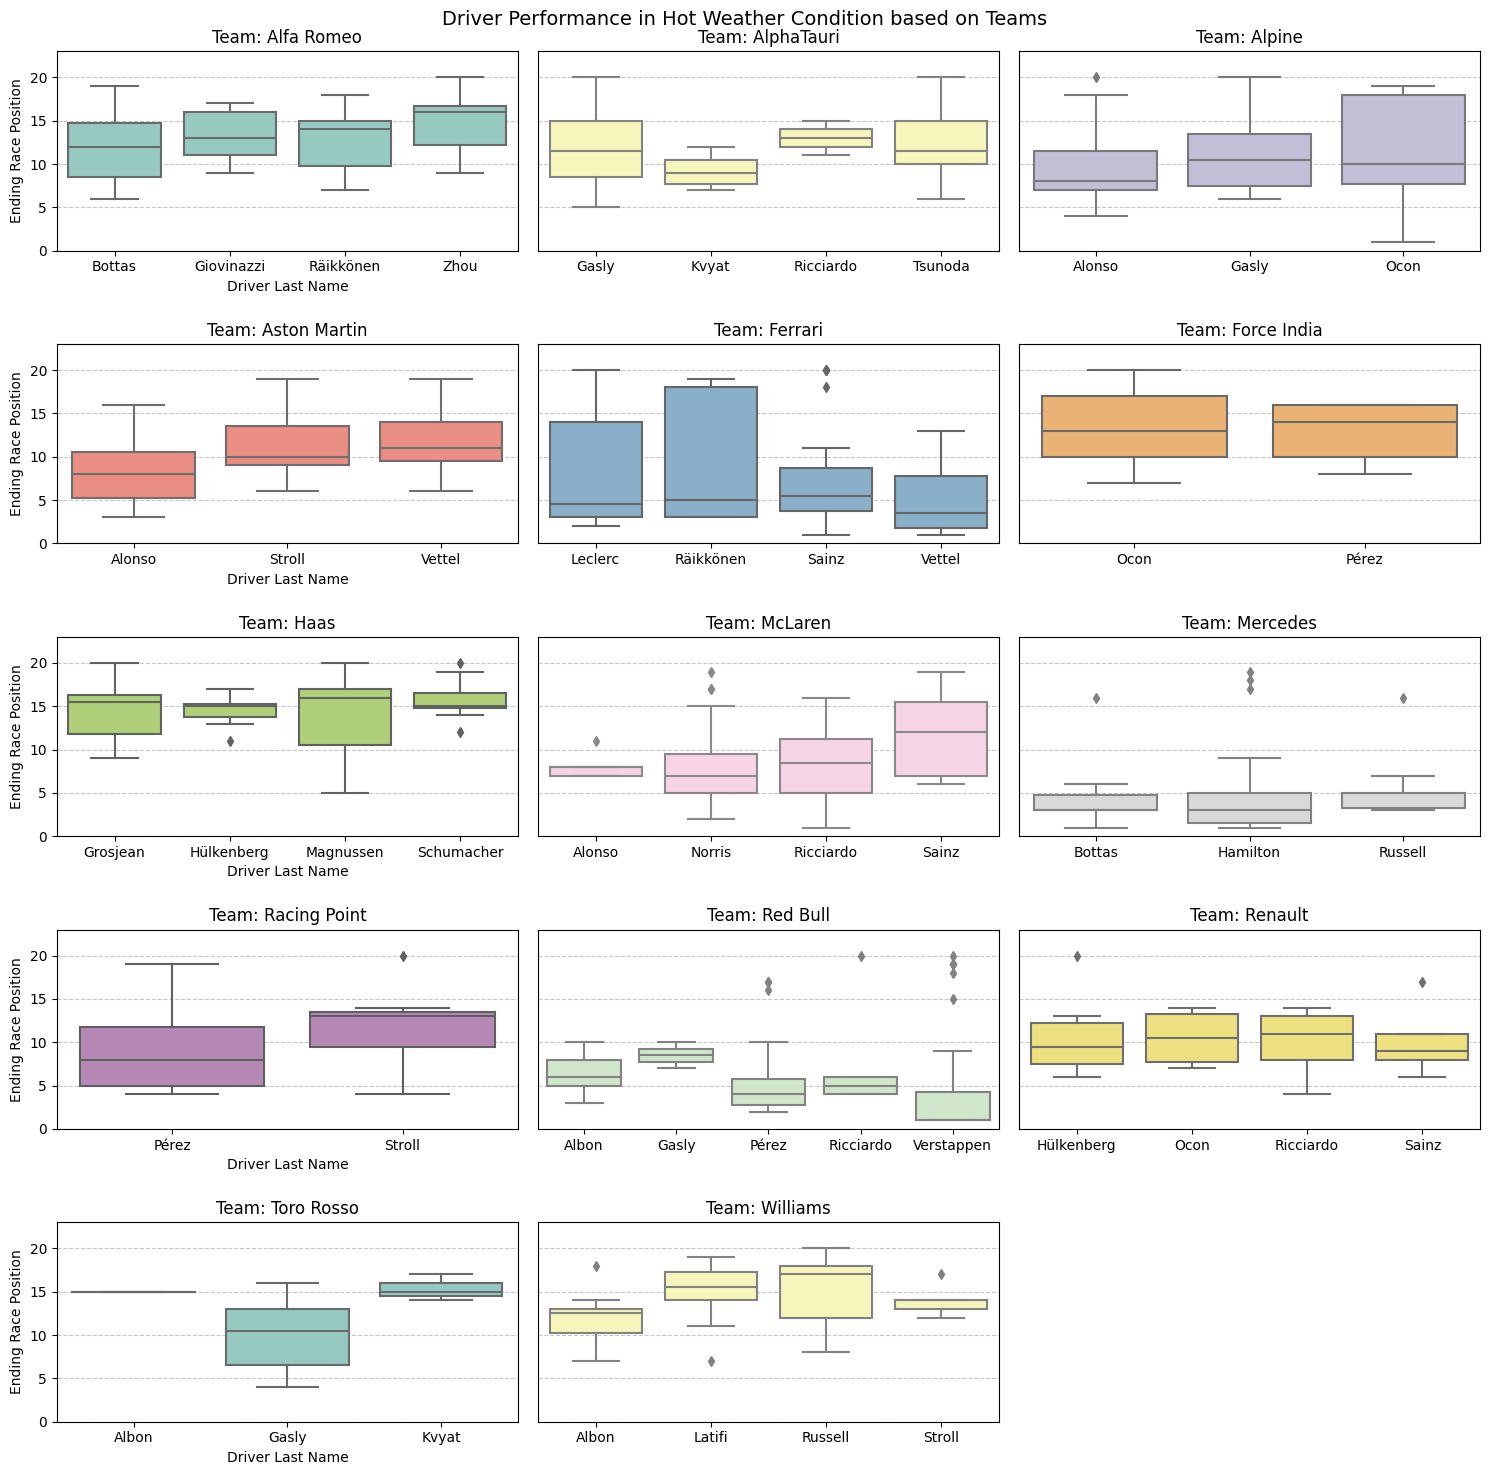

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(15, 15), squeeze=False)
axes_flat = axes.flatten()
y_axis_range =[0, 23]

for i, team in enumerate(unique_teams):
  team_data = hot_df[hot_df['team_name'] == team]
  sns.boxplot(data=team_data, x='last_name', y='Ending Race Position', ax=axes_flat[i], color=team_color_mapping[team])
  axes_flat[i].set_title(f"Team: {team}")
  axes_flat[i].set_ylim(y_axis_range)

  if i % 3 == 0:
    axes_flat[i].set_xlabel('Driver Last Name')
  else:
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_yticklabels([])
    axes_flat[i].tick_params(left = False)
  axes_flat[i].set_axisbelow(True)
  axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_flat)):
  axes_flat[j].axis('off')

plt.suptitle('Driver Performance in Hot Weather Condition based on Teams', fontsize=14)
plt.savefig('hot.png')
plt.tight_layout(h_pad=2)
plt.show()

## Cold Condition

In [ ]:
cold_df = cold_df[['team_name', 'last_name', 'ending_race_position']]

In [ ]:
cold_df = cold_df.rename(columns={'ending_race_position':'Ending Race Position'})

In [ ]:
cold_df.groupby(['team_name','last_name'])['Ending Race Position'].mean()

team_name     last_name 
Alfa Romeo    Bottas        14.000000
              Giovinazzi    14.454545
              Räikkönen     13.181818
              Zhou          14.833333
AlphaTauri    Gasly          9.909091
              Kvyat         12.666667
              Ricciardo     14.000000
              Tsunoda       14.181818
Alpine        Alonso        10.375000
              Gasly          9.000000
              Ocon          10.272727
Aston Martin  Alonso         4.666667
              Stroll        10.363636
              Vettel        11.250000
Ferrari       Leclerc        7.647059
              Räikkönen     12.000000
              Sainz          7.727273
              Vettel         5.111111
Force India   Ocon          13.666667
              Pérez          5.666667
Haas          Grosjean      13.777778
              Hülkenberg    12.666667
              Magnussen     12.571429
              Schumacher    15.875000
McLaren       Alonso        11.333333
              Norris     

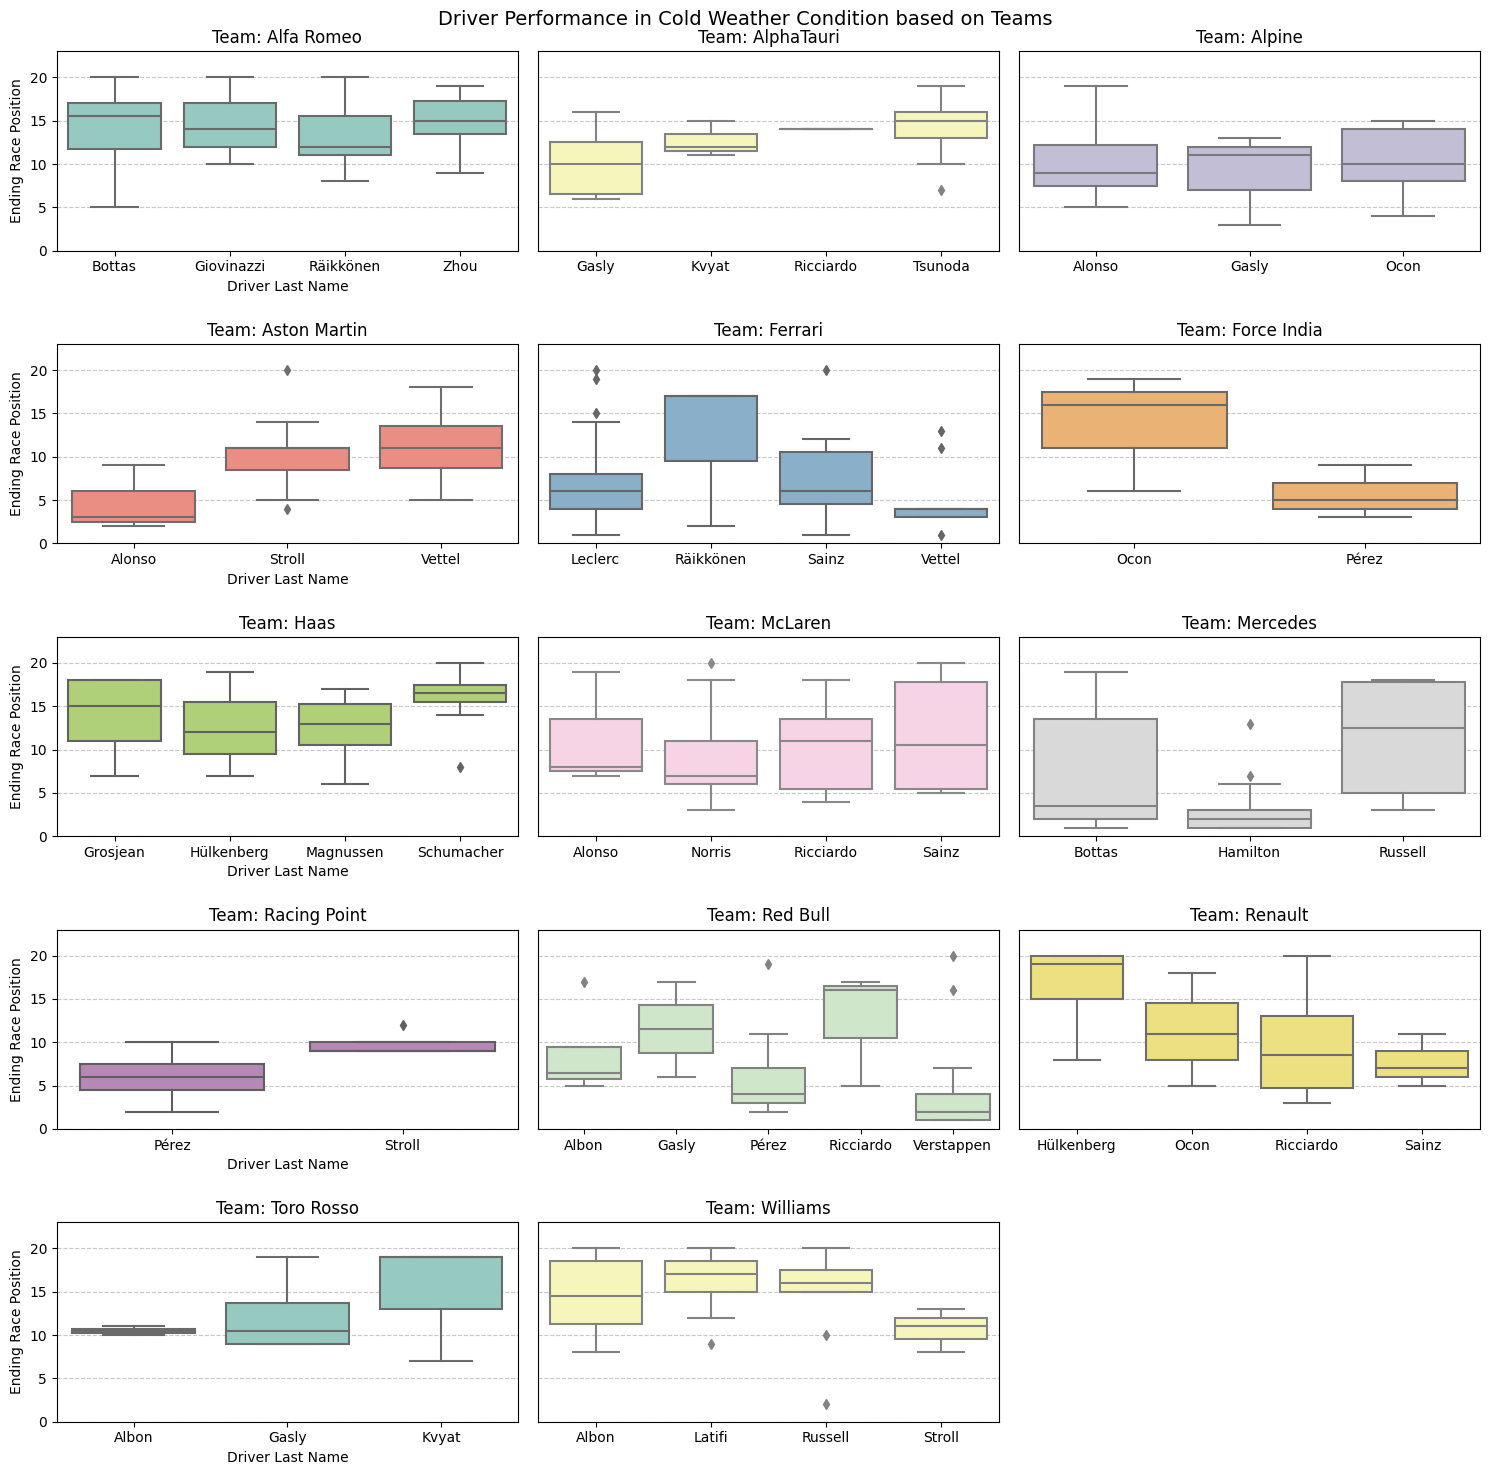

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(15, 15), squeeze=False)
axes_flat = axes.flatten()
y_axis_range =[0, 23]

for i, team in enumerate(unique_teams):
  team_data = cold_df[cold_df['team_name'] == team]
  sns.boxplot(data=team_data, x='last_name', y='Ending Race Position', ax=axes_flat[i], color=team_color_mapping[team])
  axes_flat[i].set_title(f"Team: {team}")
  axes_flat[i].set_ylim(y_axis_range)

  if i % 3 == 0:
    axes_flat[i].set_xlabel('Driver Last Name')
  else:
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_yticklabels([])
    axes_flat[i].tick_params(left = False)
  axes_flat[i].set_axisbelow(True)
  axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_flat)):
  axes_flat[j].axis('off')

plt.suptitle('Driver Performance in Cold Weather Condition based on Teams', fontsize=14)
plt.tight_layout(h_pad=2)
plt.show()

## Wet Condition

In [ ]:
wet_df = wet_df[['team_name', 'last_name', 'ending_race_position']]

In [ ]:
wet_df = wet_df.rename(columns={'ending_race_position':'Ending Race Position'})

In [ ]:
wet_df.groupby(['team_name','last_name'])['Ending Race Position'].mean()

team_name     last_name 
Alfa Romeo    Bottas        13.400000
              Giovinazzi    15.375000
              Räikkönen     13.437500
              Zhou          15.000000
AlphaTauri    Gasly         11.529412
              Kvyat         13.200000
              Ricciardo     14.500000
              Tsunoda       13.650000
Alpine        Alonso        10.083333
              Gasly          8.750000
              Ocon          10.700000
Aston Martin  Alonso         5.500000
              Stroll        11.789474
              Vettel         9.363636
Ferrari       Leclerc        8.870968
              Räikkönen      7.285714
              Sainz          7.300000
              Vettel         7.222222
Force India   Ocon          11.285714
              Pérez         10.142857
Haas          Grosjean      14.470588
              Hülkenberg    14.375000
              Magnussen     13.906250
              Schumacher    15.583333
McLaren       Alonso        15.714286
              Norris     

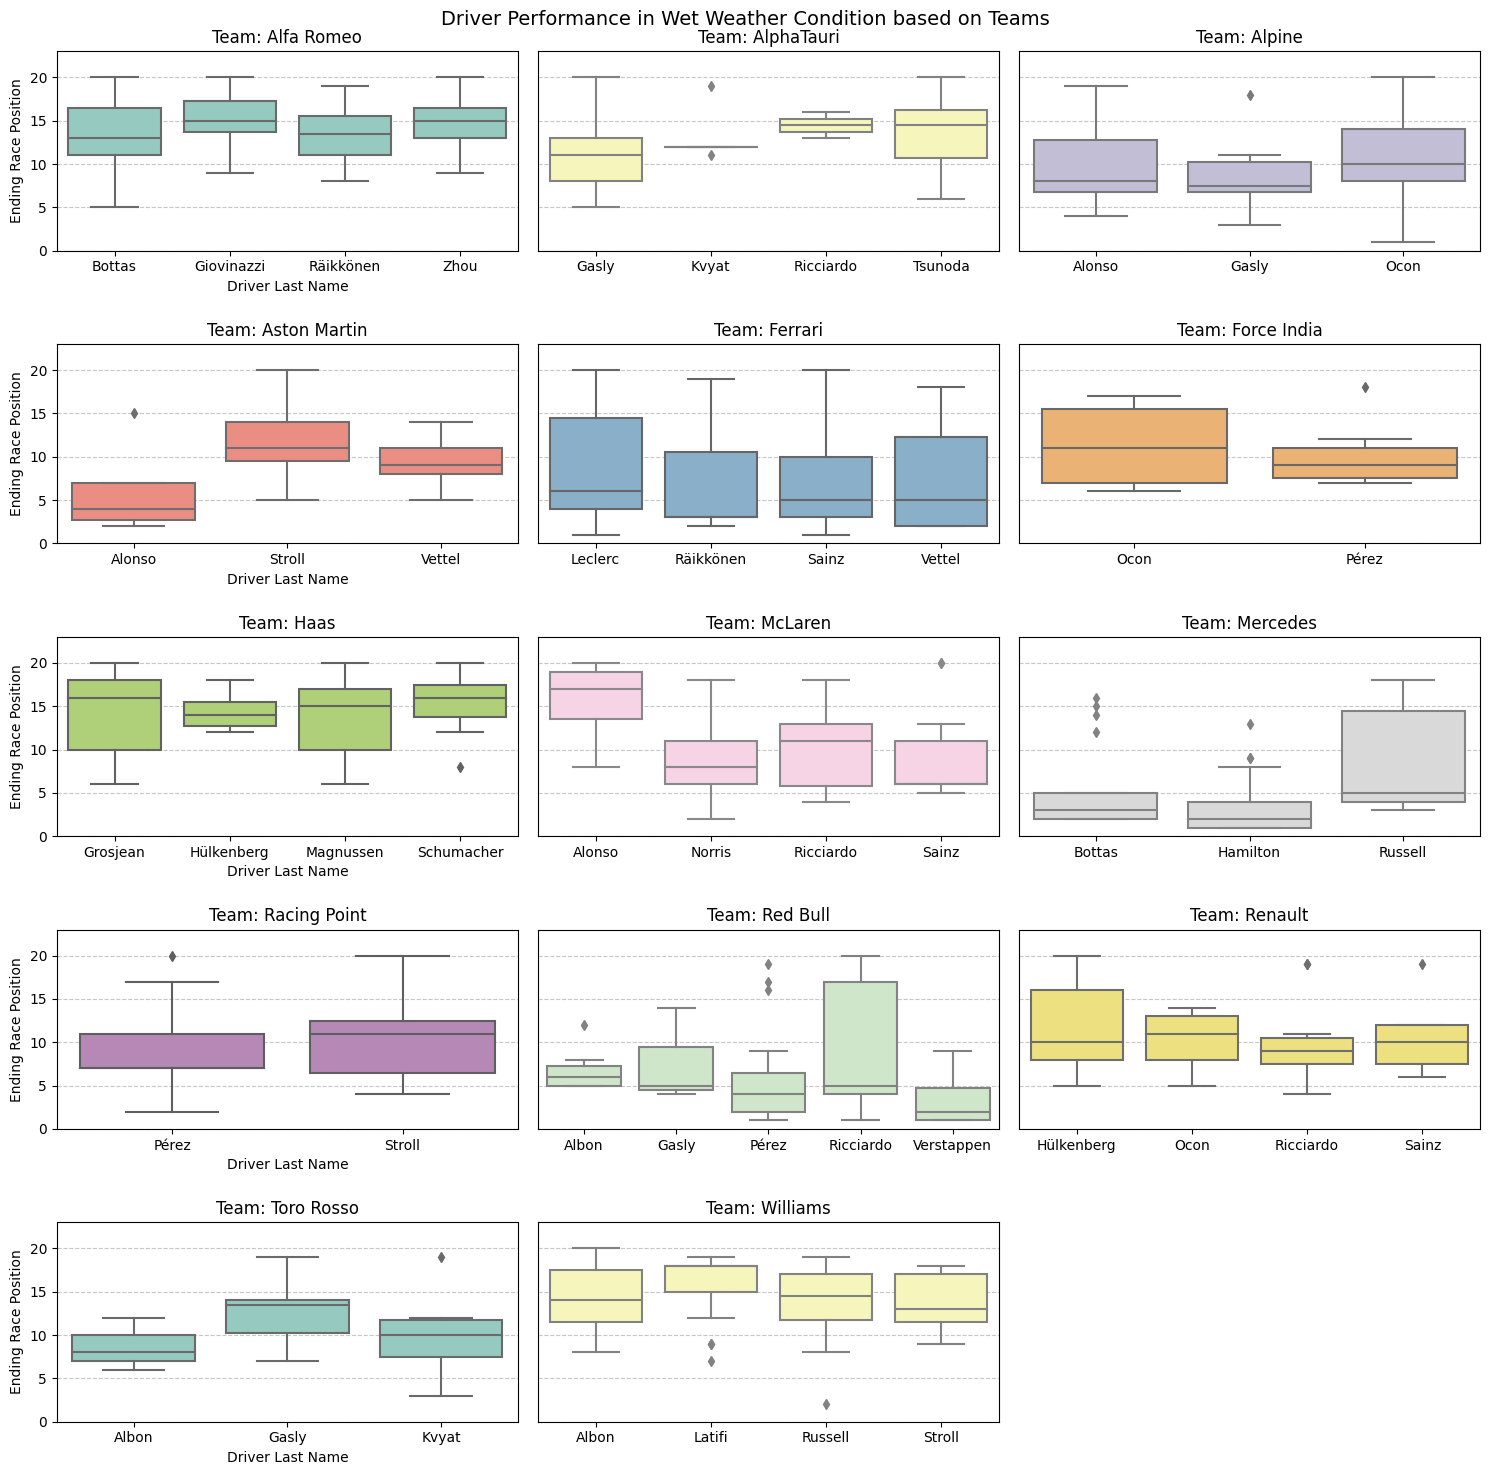

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(15, 15), squeeze=False)
axes_flat = axes.flatten()
y_axis_range =[0, 23]

for i, team in enumerate(unique_teams):
  team_data = wet_df[wet_df['team_name'] == team]
  sns.boxplot(data=team_data, x='last_name', y='Ending Race Position', ax=axes_flat[i], color=team_color_mapping[team])
  axes_flat[i].set_title(f"Team: {team}")
  axes_flat[i].set_ylim(y_axis_range)

  if i % 3 == 0:
    axes_flat[i].set_xlabel('Driver Last Name')
  else:
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_yticklabels([])
    axes_flat[i].tick_params(left = False)
  axes_flat[i].set_axisbelow(True)
  axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_flat)):
  axes_flat[j].axis('off')

plt.suptitle('Driver Performance in Wet Weather Condition based on Teams', fontsize=14)
plt.tight_layout(h_pad=2)
plt.show()

## Cold/Wet Condition

In [ ]:
cold_wet_df = cold_wet_df[['team_name', 'last_name', 'ending_race_position']]

In [ ]:
cold_wet_df = cold_wet_df.rename(columns={'ending_race_position':'Ending Race Position'})

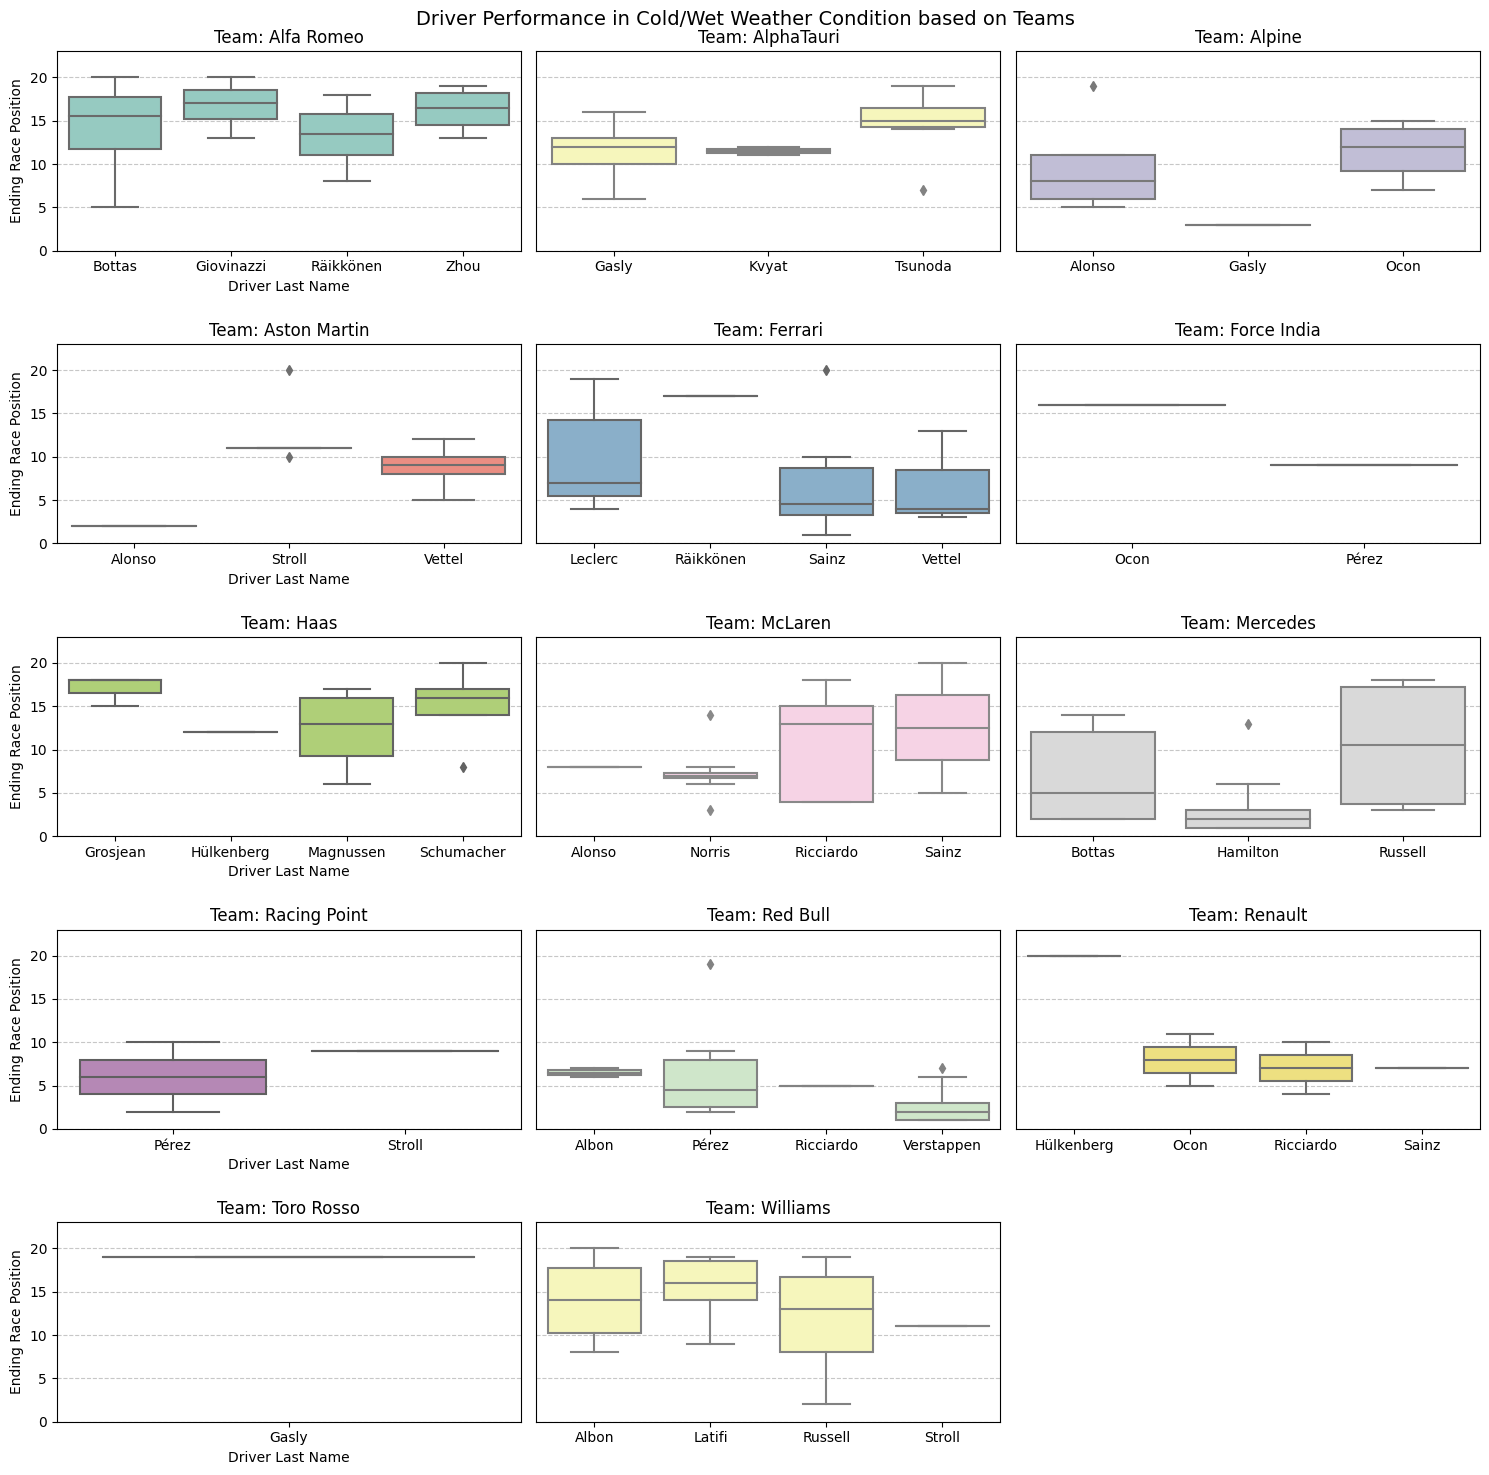

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(15, 15), squeeze=False)
axes_flat = axes.flatten()
y_axis_range =[0, 23]

for i, team in enumerate(unique_teams):
  team_data = cold_wet_df[cold_wet_df['team_name'] == team]
  sns.boxplot(data=team_data, x='last_name', y='Ending Race Position', ax=axes_flat[i], color=team_color_mapping[team])
  axes_flat[i].set_title(f"Team: {team}")
  axes_flat[i].set_ylim(y_axis_range)

  if i % 3 == 0:
    axes_flat[i].set_xlabel('Driver Last Name')
  else:
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_yticklabels([])
    axes_flat[i].tick_params(left = False)
  axes_flat[i].set_axisbelow(True)
  axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_flat)):
  axes_flat[j].axis('off')

plt.suptitle('Driver Performance in Cold/Wet Weather Condition based on Teams', fontsize=14)
plt.tight_layout(h_pad=2)
plt.show()

In [ ]:
cold_wet_df[cold_wet_df['last_name'] == 'Ricciardo']

,team_name,last_name,Ending Race Position
1644,McLaren,Ricciardo,13
64,Red Bull,Ricciardo,5
973,Renault,Ricciardo,10
1529,McLaren,Ricciardo,18
829,Renault,Ricciardo,4
1306,McLaren,Ricciardo,4
1251,McLaren,Ricciardo,4
1706,McLaren,Ricciardo,15


## Normal Conditions

In [ ]:
norm_cond_df = normal_df[['team_name', 'last_name', 'ending_race_position']]

In [ ]:
norm_cond_df = norm_cond_df.sort_values(by='last_name')

In [ ]:
norm_cond_df.shape

(909, 3)

In [ ]:
norm_cond_df = norm_cond_df.rename(columns={'ending_race_position':'Ending Race Position'})

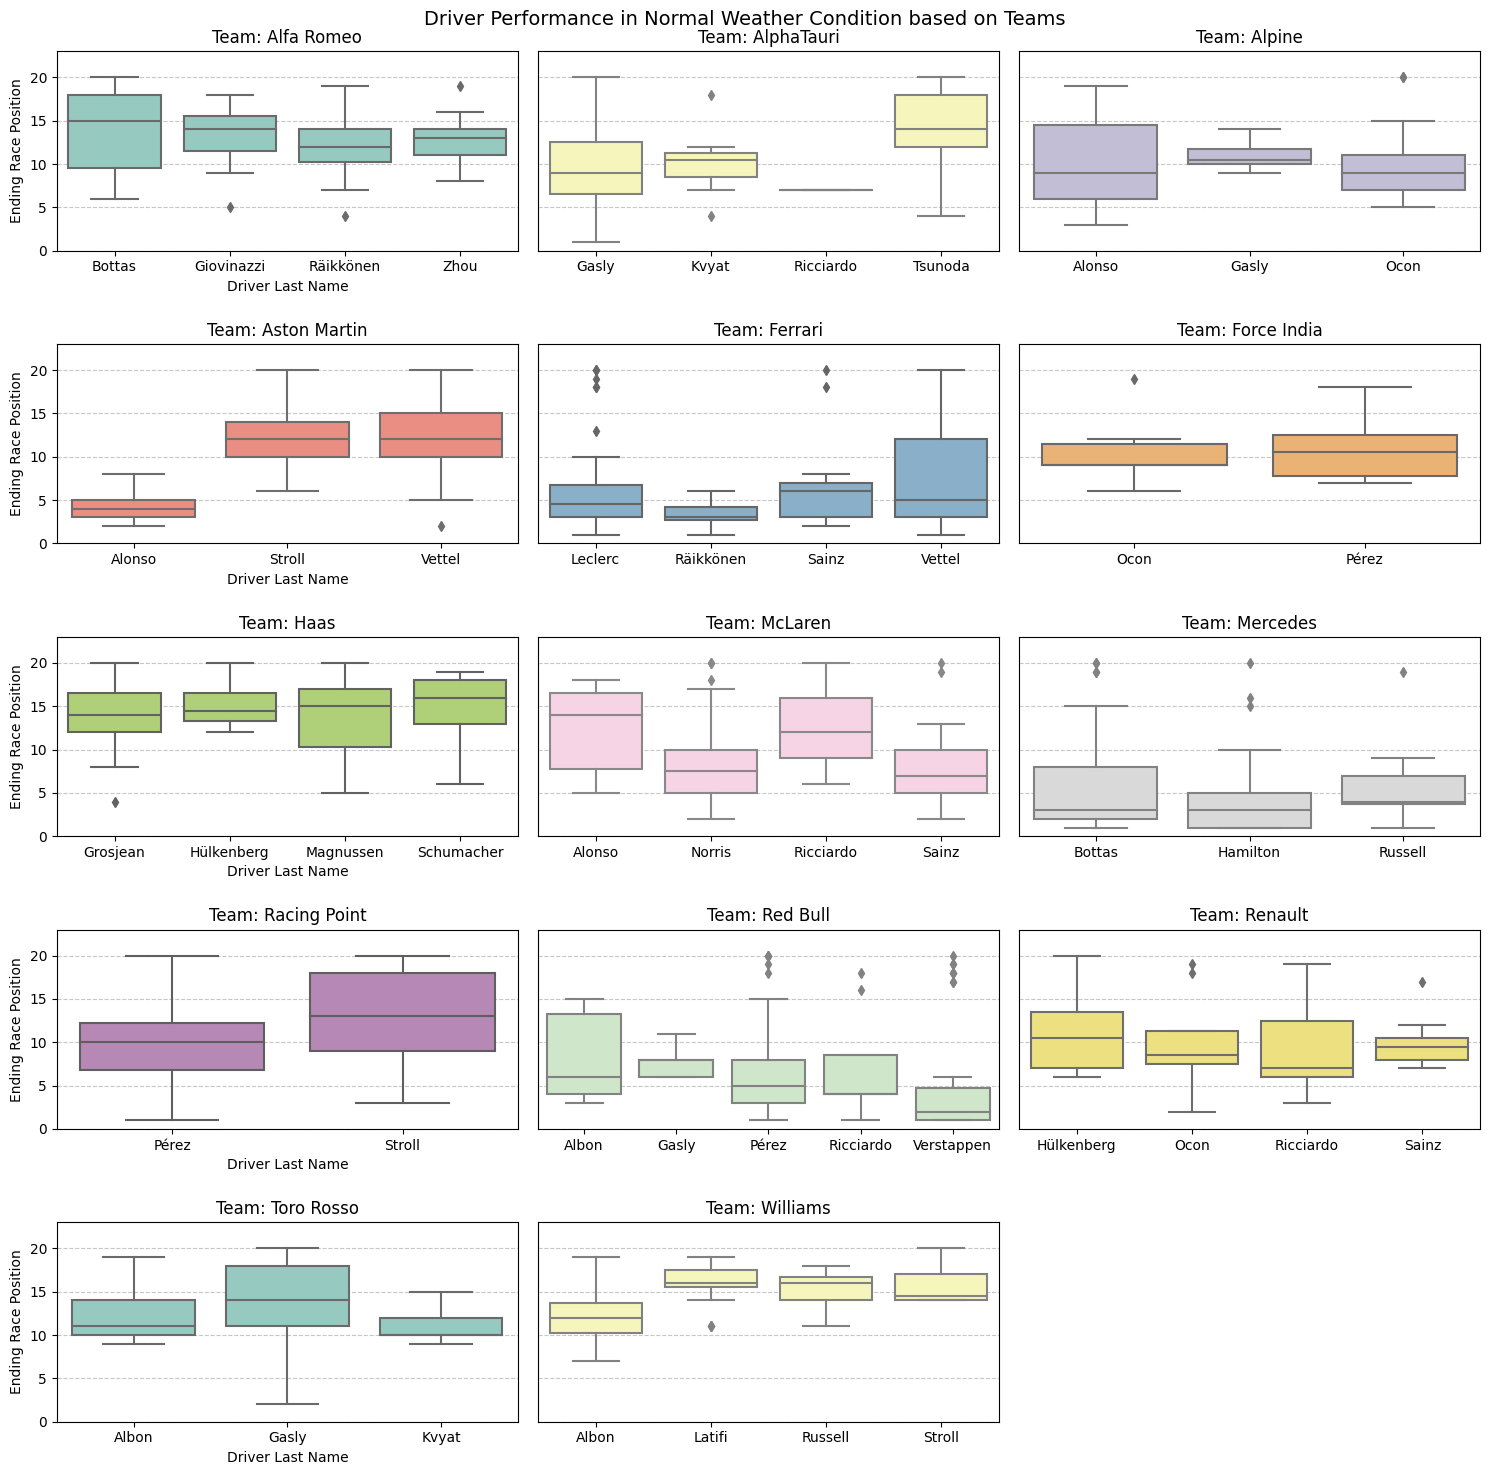

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(15, 15), squeeze=False)
axes_flat = axes.flatten()
y_axis_range =[0, 23]

for i, team in enumerate(unique_teams):
  team_data = norm_cond_df[norm_cond_df['team_name'] == team]
  sns.boxplot(data=team_data, x='last_name', y='Ending Race Position', ax=axes_flat[i], color=team_color_mapping[team])
  axes_flat[i].set_title(f"Team: {team}")
  axes_flat[i].set_ylim(y_axis_range)

  if i % 3 == 0:
    axes_flat[i].set_xlabel('Driver Last Name')
  else:
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_yticklabels([])
    axes_flat[i].tick_params(left = False)
  axes_flat[i].set_axisbelow(True)
  axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_flat)):
  axes_flat[j].axis('off')

plt.suptitle('Driver Performance in Normal Weather Condition based on Teams', fontsize=14)
plt.tight_layout(h_pad=2)
plt.show()

# Extra Viz

In [ ]:
loc_df = df.groupby(['lat', 'lng', 'circuit_name', 'circuit_ref']).size().reset_index(name='count')

In [ ]:
loc_df.head()

,lat,lng,circuit_name,circuit_ref,count
0,-37.8497,144.9680,Albert Park Grand Prix Circuit,albert_park,71
1,-23.7036,-46.6997,Autódromo José Carlos Pace,interlagos,91
2,1.2914,103.8640,Marina Bay Street Circuit,marina_bay,70
3,19.4042,-99.0907,Autódromo Hermanos Rodríguez,rodriguez,89
4,21.6319,39.1044,Jeddah Corniche Circuit,jeddah,54


<ipython-input-93-d4836213d36b>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


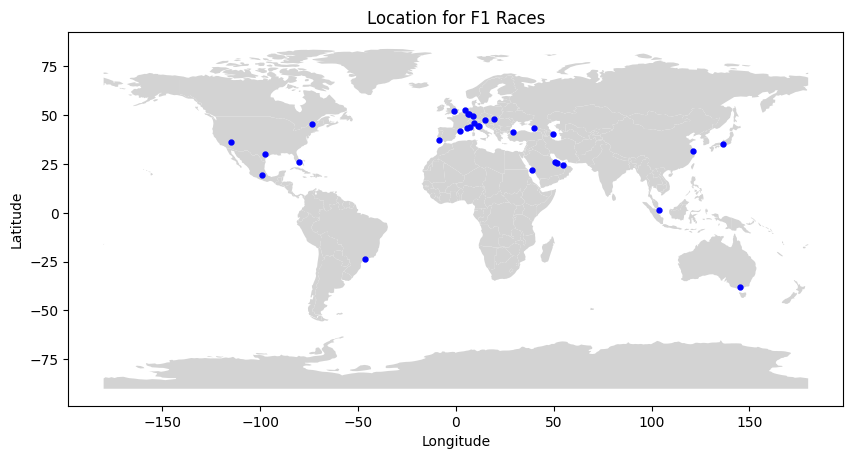

In [ ]:
geometry = [Point(xy) for xy in zip(loc_df['lng'], loc_df['lat'])]
geo_df = gpd.GeoDataFrame(loc_df, geometry=geometry)

# Step 2: Load World Map Data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')  # Background world map
geo_df.plot(ax=ax, marker='.', color='blue', markersize=50)  # Plot points

# Additional Plot Customization
plt.title('Location for F1 Races')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Heatmaps

In [ ]:
top_drivers = abnormal_df.groupby('last_name')['ending_race_position'].mean().nsmallest(10).index
top_circuits = abnormal_df.groupby('circuit_name')['ending_race_position'].mean().nsmallest(10).index
filtered_df = abnormal_df[abnormal_df['last_name'].isin(top_drivers) & abnormal_df['circuit_name'].isin(top_circuits)]

In [ ]:
filtered_df.shape

(265, 32)

In [ ]:
average_positions = filtered_df.groupby(['circuit_name', 'last_name'])['ending_race_position'].mean().reset_index()

In [ ]:
circuit_performance = average_positions.groupby('circuit_name')['ending_race_position'].mean().sort_values(ascending=False)
sorted_circuits = circuit_performance.index.tolist()

In [ ]:
pivot_df = average_positions.pivot(index='circuit_name', columns='last_name', values='ending_race_position')
pivot_df = pivot_df.reindex(sorted_circuits)

In [ ]:
pivot_df.head()

last_name,Alonso,Bottas,Hamilton,Leclerc,Norris,Pérez,Ricciardo,Sainz,Verstappen,Vettel
circuit_name,,,,,,,,,,
Bahrain International Circuit,5.000000,5.0,4.0,19.0,17.00,9.0,20.0,7.5,10.0,1.00
Miami International Autodrome,7.000000,10.0,6.0,4.5,18.00,3.0,13.0,4.0,1.0,17.00
Circuit de Spa-Francorchamps,11.666667,6.6,2.4,6.5,9.75,8.4,10.8,15.8,5.6,5.75
Autódromo José Carlos Pace,10.000000,10.5,4.5,20.0,2.00,7.0,8.5,9.0,1.5,6.00
Hungaroring,7.250000,11.2,2.0,10.5,9.25,9.2,10.2,6.6,6.4,6.00


In [ ]:
pivot_df = pivot_df.dropna()

In [ ]:
pivot_df_rounded = np.ceil(pivot_df).astype(int)

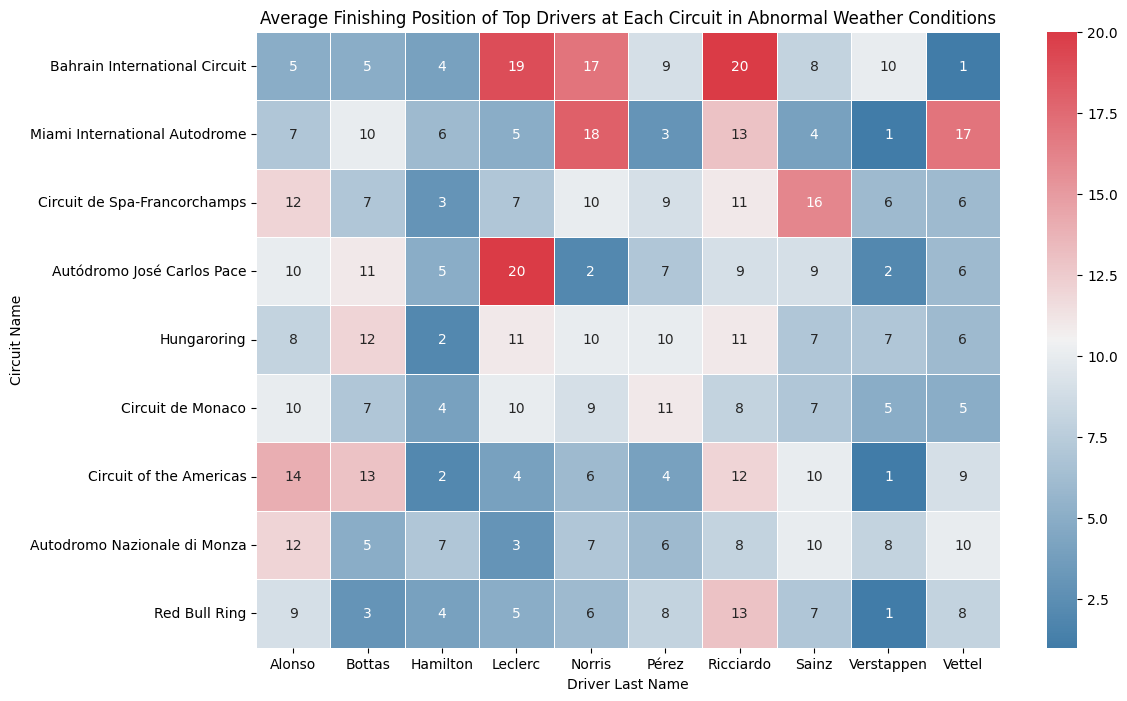

In [ ]:
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(pivot_df_rounded, annot=True, cmap=cmap, linewidths=.5)
plt.title('Average Finishing Position of Top Drivers at Each Circuit in Abnormal Weather Conditions')
plt.xlabel('Driver Last Name')
plt.ylabel('Circuit Name')
plt.show()

In [ ]:
top_drivers_norm = normal_df.groupby('last_name')['ending_race_position'].mean().nsmallest(10).index
top_circuits_norm = normal_df.groupby('circuit_name')['ending_race_position'].mean().nsmallest(10).index
filtered_df_norm = normal_df[normal_df['last_name'].isin(top_drivers) & normal_df['circuit_name'].isin(top_circuits)]

In [ ]:
filtered_df_norm.shape

(213, 32)

In [ ]:
average_positions_norm = filtered_df_norm.groupby(['circuit_name', 'last_name'])['ending_race_position'].mean().reset_index()

In [ ]:
circuit_performance_norm = average_positions_norm.groupby('circuit_name')['ending_race_position'].mean().sort_values(ascending=False)
sorted_circuits_norm = circuit_performance_norm.index.tolist()

In [ ]:
pivot_df_norm = average_positions_norm.pivot(index='circuit_name', columns='last_name', values='ending_race_position')
pivot_df_norm = pivot_df_norm.reindex(sorted_circuits)

In [ ]:
pivot_df_norm = pivot_df_norm.dropna()

In [ ]:
pivot_df_rounded_norm = np.ceil(pivot_df_norm).astype(int)

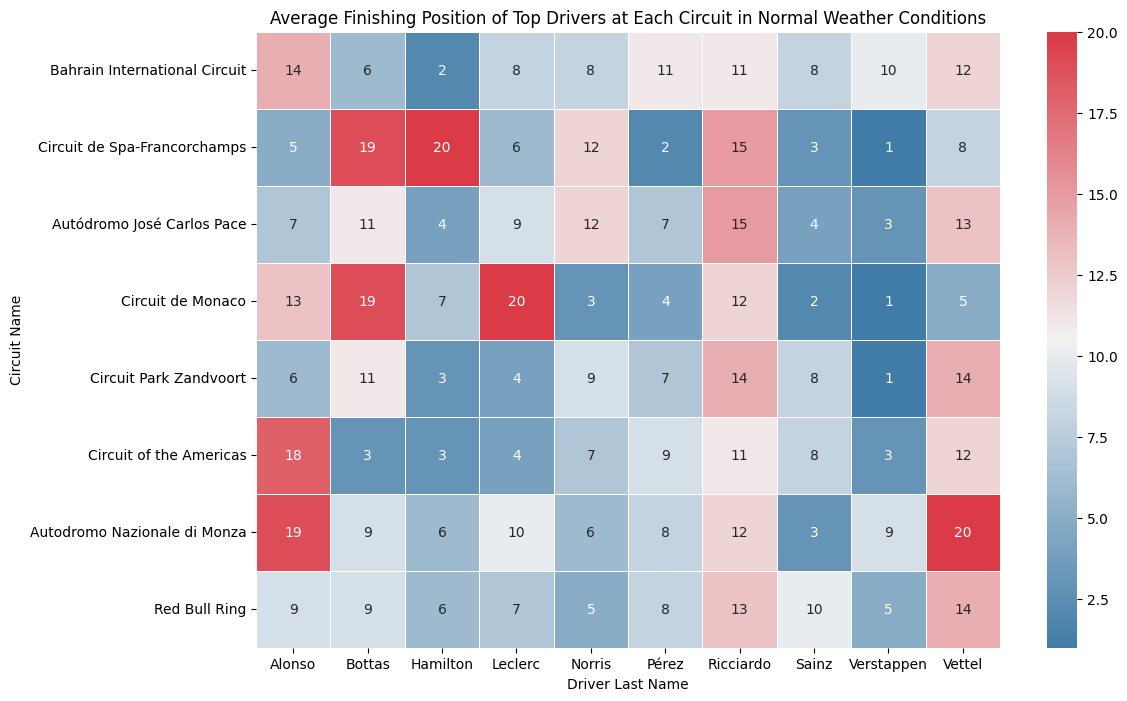

In [ ]:
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(pivot_df_rounded_norm, annot=True, cmap=cmap, linewidths=.5)
plt.title('Average Finishing Position of Top Drivers at Each Circuit in Normal Weather Conditions')
plt.xlabel('Driver Last Name')
plt.ylabel('Circuit Name')
plt.show()

#Tables

In [ ]:
driver_merge.sort_values(by='Abnormal', ascending=True).reset_index(drop=True)

,last_name,Normal,Abnormal
0,Leclerc,-0.261905,-2.590164
1,Hülkenberg,-2.681818,-2.048780
2,Grosjean,-3.260870,-1.606061
3,Räikkönen,1.676471,-1.488889
4,Russell,0.642857,-1.274194
5,Magnussen,-2.263158,-1.274194
6,Sainz,-0.020000,-1.146667
7,Zhou,1.133333,-1.103448
8,Tsunoda,-1.320000,-1.024390
9,Bottas,-2.300000,-0.786667


In [ ]:
df.groupby(['last_name', 'first_name'])['race_id'].size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,last_name,first_name,count
0,Bottas,Valtteri,125
1,Gasly,Pierre,125
2,Verstappen,Max,125
3,Sainz,Carlos,125
4,Hamilton,Lewis,123
5,Stroll,Lance,123
6,Pérez,Sergio,123
7,Ricciardo,Daniel,109
8,Russell,George,104
9,Norris,Lando,103


In [ ]:
df.groupby(['team_name'])['race_id'].size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,team_name,count
0,Red Bull,250
1,Ferrari,249
2,Mercedes,249
3,Haas,221
4,Alfa Romeo,206
5,McLaren,206
6,Williams,184
7,AlphaTauri,151
8,Alpine,132
9,Aston Martin,127


In [ ]:
df.groupby(['circuit_name'])['race_id'].nunique().reset_index(name='count')

,circuit_name,count
0,Albert Park Grand Prix Circuit,4
1,Autodromo Enzo e Dino Ferrari,3
2,Autodromo Internazionale del Mugello,1
3,Autodromo Nazionale di Monza,6
4,Autódromo Hermanos Rodríguez,5
5,Autódromo Internacional do Algarve,2
6,Autódromo José Carlos Pace,5
7,Bahrain International Circuit,7
8,Baku City Circuit,5
9,Circuit Gilles Villeneuve,4


In [ ]:
df.groupby(['last_name', 'first_name', 'team_name'])['race_id'].size().reset_index(name='count')

,last_name,first_name,team_name,count
0,Albon,Alexander,Red Bull,26
1,Albon,Alexander,Toro Rosso,12
2,Albon,Alexander,Williams,43
3,Alonso,Fernando,Alpine,44
4,Alonso,Fernando,Aston Martin,21
5,Alonso,Fernando,McLaren,21
6,Bottas,Valtteri,Alfa Romeo,44
7,Bottas,Valtteri,Mercedes,81
8,Gasly,Pierre,AlphaTauri,61
9,Gasly,Pierre,Alpine,22


In [ ]:
average_positions_norm

,circuit_name,last_name,ending_race_position
0,Autodromo Nazionale di Monza,Alonso,19.000000
1,Autodromo Nazionale di Monza,Bottas,9.000000
2,Autodromo Nazionale di Monza,Hamilton,6.000000
3,Autodromo Nazionale di Monza,Leclerc,10.000000
4,Autodromo Nazionale di Monza,Norris,5.500000
5,Autodromo Nazionale di Monza,Pérez,8.000000
6,Autodromo Nazionale di Monza,Ricciardo,11.500000
7,Autodromo Nazionale di Monza,Sainz,3.000000
8,Autodromo Nazionale di Monza,Verstappen,9.000000
9,Autodromo Nazionale di Monza,Vettel,20.000000
